In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def text_similarity(text1, text2):
    vectorizer = TfidfVectorizer().fit_transform([text1, text2])
    vectors = vectorizer.toarray()
    csim = cosine_similarity(vectors)
    return csim[0,1]

text1 = "Đây là đoạn văn bản đầu tiên."
text2 = "Đây là đoạn văn bản thứ hai."

print("Độ tương tự giữa hai đoạn văn là: ", text_similarity(text1, text2) * 100, "%")

In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.3 MB/s eta 0:00:00


Saving test.csv to test (1).csv
Saving train.csv to train (1).csv
SVM accuracy score:  0.9184149184149184


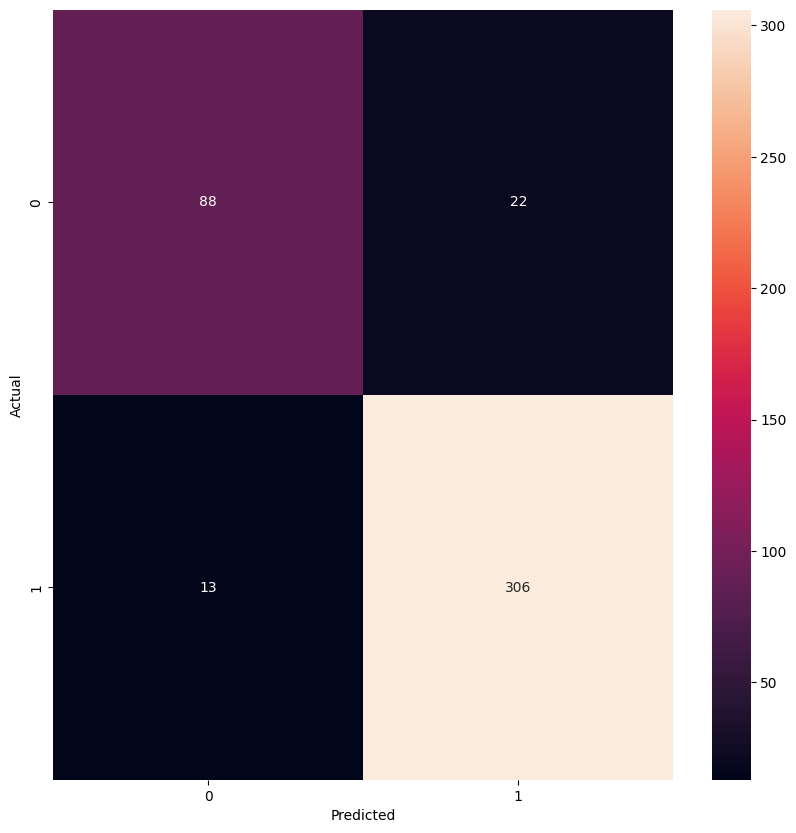

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import files
from sklearn.svm import LinearSVC

# Upload train.csv and test.csv from local machine to Colab
uploaded = files.upload()

# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Preprocessing
# Combine the 'description_x' and 'description_y' columns
train['description'] = train['description_x'] + ' ' + train['description_y']
test['description'] = test['description_x'] + ' ' + test['description_y']

# Convert text to lower case
train['description'] = train['description'].str.lower()
test['description'] = test['description'].str.lower()

# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(train['description'], train['same_security'], test_size=0.2, random_state=42)

# Fit TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# Convert labels to integers
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

# Fit SVM model
model = svm.SVC()
model.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred = model.predict(X_val_tfidf)
print("SVM accuracy score: ", accuracy_score(y_val, y_pred))

# Confusion Matrix
conf_mat = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [ ]:
# Bag of Words with LSTM
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

# set parameters:
max_features = 5000
maxlen = 400
batch_size = 32
embedding_dims = 50
epochs = 5

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

# Plot results
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model_bert = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Prepare the data for BERT
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, text_a = x[DATA_COLUMN], text_b = None, label = x[LABEL_COLUMN]), axis = 1)
  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, text_a = x[DATA_COLUMN], text_b = None, label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] 
    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length,
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True,
            truncation=True
        )
        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"], input_dict["token_type_ids"], input_dict['attention_mask'])
        features.append(InputFeatures(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label))

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

DATA_COLUMN = 'description'
LABEL_COLUMN = 'same_security'

train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

# Train the model
model_bert.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])
model_bert.fit(train_data, epochs=2, validation_data=validation_data)
